In [1]:
import json_lines
from langdetect import detect
from langdetect import detect_langs
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.neural_network import MLPClassifier
import numpy as np

from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

lemmatizer = WordNetLemmatizer()
REMOVEABLE_CHARS = "»<>123456789\/&()?:!.,;'´+*"
ALL_TAGS = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT',
 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP',
 'WP$', 'WRB']
ACCEPTABLE_TAGS = ALL_TAGS
# ACCEPTABLE_TAGS = ['CC', 'DT', 'EX', 'FW', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'PDT',
#  'POS', 'PRP', 'PRP$', 'RP', 'TO', 'UH', 'VBD', 'VBG', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']
MAX_FEATURES = 200
MIN_ENGLISH = 0.9999
LIMIT_INPUT_ROWS = 3000 # to stop run times hindering development (making this < 500 usually makes the graph angry)

def get_wordnet_pos(tag): # Return a char, based on input tag, that is used as a param in lemmatisation for enhanced results
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [2]:
# READ IN INFO
reviews= []; polarity= []; are_early= [];
with open ('reviews.json', 'rb') as f:
    i= 0
    for item in json_lines.reader(f):
        if i < LIMIT_INPUT_ROWS:
            try:
                langs = detect_langs(item['text'])
            except:
                pass
            for lang in langs:
                if str(lang)[0:2] == 'en':
                    if float(str(lang)[3:]) > MIN_ENGLISH:
                        reviews.append(item['text'])
                        polarity.append(item['voted_up'])
                        are_early.append(item['early_access'])
                        i+= 1
                        break
        else:
            break
        

In [3]:
# FILTER TEXT
for i, text in enumerate(reviews):
    text_words = nltk.word_tokenize(text.lower())
    tags = nltk.pos_tag(text_words)
    #print(tags)
    new_text= [];
    for j, word in enumerate(text_words):
        for char in word:
            if char in REMOVEABLE_CHARS:
                break
        else:
            wordnet_pos = get_wordnet_pos(tags[j][1])
            if wordnet_pos != '':
                new_text.append(lemmatizer.lemmatize(word, wordnet_pos))
            continue
    reviews[i] = new_text

for i, text in enumerate(reviews): 
    new_text= []
    tags = nltk.pos_tag(reviews[i])
    for j, word in enumerate(text):
        if tags[j][1] in ACCEPTABLE_TAGS:
            new_text.append(word)
    reviews[i] = new_text
    #print(tags)

In [4]:
# MOST FREQ WORDS AS FEATURES
word_counts = {}
for text in reviews:
    for word in text:
        if word in word_counts:
            word_counts[word]+= 1
        else:
            word_counts[word]= 1
word_counts= {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)}
trimd_word_counts= {}
if len(word_counts) > MAX_FEATURES:
    for i, entry in enumerate(word_counts):
        if i >= MAX_FEATURES:
            break
        trimd_word_counts[entry]= word_counts[entry]
    word_counts= trimd_word_counts
tags = nltk.pos_tag(word_counts.keys()); # this part is just for the below print statement
for i, word in enumerate(word_counts):
    print("word: ", word, "| tag: ", tags[i][1], "| count: ",word_counts[word],"\n")

word:  be | tag:  VB | count:  4953 

word:  game | tag:  NN | count:  3352 

word:  i | tag:  NN | count:  2856 

word:  have | tag:  VBP | count:  1384 

word:  do | tag:  VBN | count:  1076 

word:  not | tag:  RB | count:  882 

word:  play | tag:  VB | count:  834 

word:  get | tag:  VB | count:  790 

word:  just | tag:  RB | count:  551 

word:  good | tag:  JJ | count:  516 

word:  so | tag:  RB | count:  473 

word:  make | tag:  JJ | count:  466 

word:  time | tag:  NN | count:  461 

word:  more | tag:  RBR | count:  424 

word:  even | tag:  RB | count:  375 

word:  really | tag:  RB | count:  362 

word:  fun | tag:  JJ | count:  343 

word:  go | tag:  VB | count:  326 

word:  very | tag:  RB | count:  310 

word:  only | tag:  RB | count:  304 

word:  buy | tag:  VB | count:  283 

word:  well | tag:  RB | count:  276 

word:  player | tag:  NN | count:  273 

word:  much | tag:  JJ | count:  270 

word:  want | tag:  VBP | count:  259 

word:  bad | tag:  JJ | cou

In [5]:
# CREATE 1-HOT ENCODINGS
amount_features = len(word_counts)
one_hots = []
for text in reviews:
    one_hot = []
    for i in range(MAX_FEATURES):
        one_hot.append(0)
    for word in text:
        if word in word_counts:
            one_hot[list(word_counts).index(word)]+= 1
    one_hots.append(one_hot)

for i, one_hot in enumerate(one_hots): # convert array of lists into 2d array
    one_hot_arr = np.array(one_hot)
    one_hots[i] = one_hot_arr
x_one_hots = np.array(one_hots)

y_one_hot= np.array(polarity, dtype=np.int)

overall accuracy:  0.9579611140304782


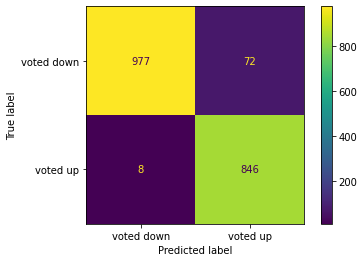

In [6]:
# SPLIT, TRAIN, PREDICT, GRAPH
y_tests= []
y_trains= []
X_train_scaleds= []
X_test_scaleds= []
kfold= KFold(5, shuffle=True, random_state=1)
for train_index, test_index in kfold.split(x_one_hots):
    #print('train_index: '+str(train_index))
    #print('test_index: '+str(test_index))
    #print('train: %s, test: %s' % (x_one_hots[train_index], x_one_hots[test_index]))
    y_train= []
    y_test= []
    for index in train_index:
        y_train.append(y_one_hot[index])
    for index in test_index:
        y_test.append(y_one_hot[index])
    X_train= x_one_hots[train_index]
    X_test= x_one_hots[test_index]
    sc_X= StandardScaler()
    X_train_scaled= sc_X.fit_transform(X_train)
    X_test_scaled= sc_X.transform(X_test)
    X_train_scaleds+= X_train_scaled.tolist()
    X_test_scaleds+= X_test_scaled.tolist()
    y_tests+= y_test
    y_trains+= y_train
    
clf= MLPClassifier(hidden_layer_sizes=(amount_features, int(amount_features/2), int(amount_features/4)), activation="relu", solver="adam", random_state=1).fit(X_train_scaleds, y_trains)
y_preds= clf.predict(X_test_scaleds)

print("overall accuracy: ", clf.score(X_test_scaleds, y_tests))
try:
    fig= plot_confusion_matrix(clf, X_test_scaleds, y_tests, display_labels=["voted down", "voted up"])
except ValueError:
    pass